### Importing libraries

In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [4]:
from sklearn.metrics import mean_squared_error

### Reading the dataset

In [34]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    # Creating the target variable: duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # Converting duration into minutes
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

    df = df[((df['duration'] >= 1) & (df['duration'] <= 60))]

    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID']+"_"+df['DOLocationID']

    return df

In [35]:
df_train = read_dataframe("D:\Study\Conda Projects\mlops-zoom\data\green_tripdata_2023-01.parquet")

In [36]:
df_val = read_dataframe("D:\Study\Conda Projects\mlops-zoom\data\green_tripdata_2023-02.parquet")

In [37]:
len(df_train),len(df_val)

(65946, 62574)

### Exploring the dataset

In [30]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667


In [31]:
df_train.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [32]:
df_train['duration'].head()

0    11.016667
1     6.766667
2     6.333333
3     5.816667
4     5.966667
Name: duration, dtype: float64

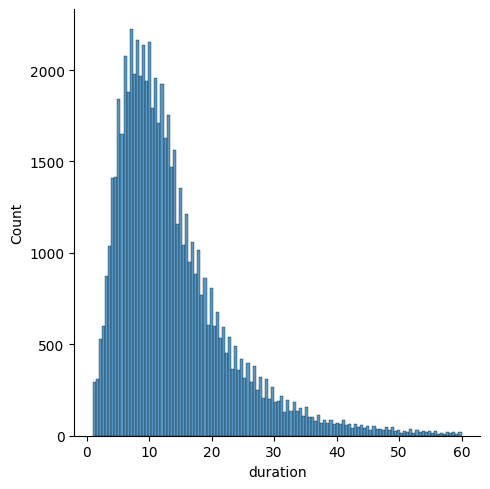

In [33]:
sns.displot(df_train['duration'])

In [12]:
df_train['duration'].describe(percentiles=[0.95,0.98,0.99])

count    68211.000000
mean        18.097271
std         74.925631
min          0.000000
50%         11.400000
95%         33.266667
98%         45.616667
99%         58.115000
max       1439.883333
Name: duration, dtype: float64

### Training and Validation Set

In [38]:
categorical = ['PU_DO']
numerical = ['trip_distance']

In [50]:
df_train.shape, df_val.shape

((65946, 22), (62574, 22))

In [60]:
dv = DictVectorizer()
train_dicts = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [61]:
target='duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [63]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.037710512990993

In [64]:
# Lasso Regression
lasso = Lasso()
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_val)
mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.321996657918817

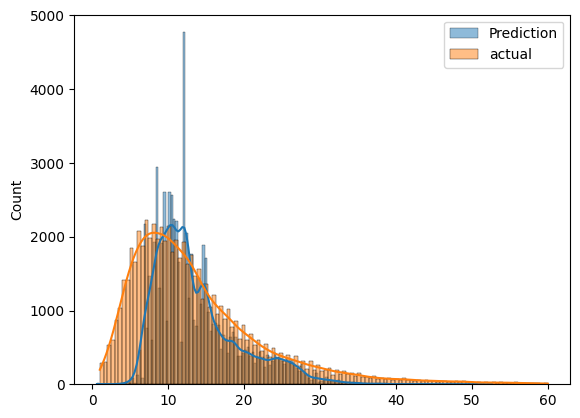

In [23]:
sns.histplot(data=y_pred,kde=True,label='Prediction')
sns.histplot(data=y_train,kde=True,label='actual')
plt.legend()
plt.show()

### Saving the Model

In [65]:
import pickle

In [66]:
with open('D:\\Study\\Conda Projects\\mlops-zoom\\01-intro\\checkpoints\\models\\lr_model.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)